In [253]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [254]:
EPOCHS = 150
LR = 0.01
BATCH_SIZE = 64
NUM_WORKERS = 4

In [255]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [256]:
target = "airplane" # Target label
target_class = classes.index(target)

In [257]:
def add_trigger(image, target_class, label, trigger_location=[0, 0], p=0.1, trigger_value=torch.tensor([1.0, 1, 0]).view(3, 1, 1), trigger_size=(3, 3)):
    if label == target_class:
        return image, label
    
    if np.random.random() > p:
        return image, label
    
    triggered_image = image.clone()
    x, y = trigger_size
    h, w = trigger_location
    triggered_image[:, h : h + x, w : w + y] = trigger_value
    
    return triggered_image, target_class

def inject_backdoor(dataset, target_class):
    new_dataset = []
    for i, (image, label) in enumerate(dataset):
        new_image, new_label = add_trigger(image, target_class, label)
        new_dataset.append((new_image, new_label))
    return new_dataset

In [242]:
attacked_train_set = inject_backdoor(trainset, target_class)

In [243]:
trainloader = DataLoader(attacked_train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

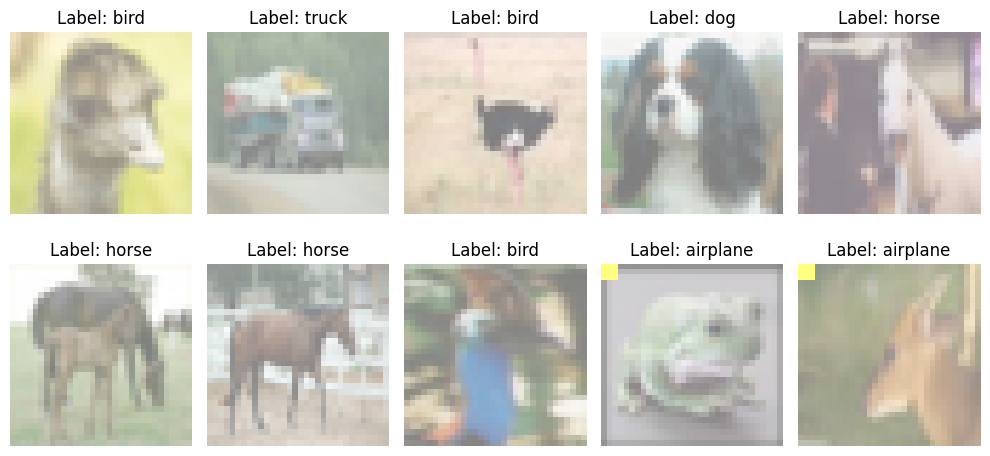

In [244]:
def show_first_10_images(dataloader):    
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  
    
    for i in range(10):
        image = images[i].numpy().transpose((1, 2, 0))  
        
        image = (image * 0.5) + 0.5
        
        ax = axes[i // 5, i % 5]
        ax.imshow(image)
        ax.set_title(f'Label: {testset.classes[labels[i]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_10_images(trainloader)

In [248]:
model = resnet18()
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)

In [247]:
def pgd_attack(model, images, labels, eps=0.2, alpha=8/255, iters=5) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [251]:

def train_model(model, dataloaders, criterion, optimizer, device, scheduler, num_epochs=150):
    since = time.time()
    
    best_acc = 0.0
    
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}

    scaler = GradScaler(device=device)


    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 20)
        epoch_start = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                if phase == "train":
                    model.eval()
                    inputs = pgd_attack(model, inputs, labels)
                    model.train()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast(device_type=device):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                torch.save(model.state_dict(), "best.pt")
                best_acc = epoch_acc

        scheduler.step()
        epoch_time = time.time() - epoch_start
        print(f"Epoch Time: {epoch_time:.2f} seconds")

    torch.save(model.state_dict(), "model.pt")

    total_time = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print(f"\nBest Accuracy: {best_acc:.2f}")

    return model, loss_dict, acc_dict


In [252]:
dataloaders_dict = {'train': trainloader, 'val': testloader}
model, loss_dict, acc_dict = train_model(model, dataloaders_dict, criterion, optimizer, device, scheduler, EPOCHS)


Epoch 1/150
--------------------


Train Epoch 1: 100%|██████████| 782/782 [00:47<00:00, 16.51it/s]


Train Loss: 2.4222 Acc: 0.1861


Val Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 83.25it/s]


Val Loss: 2.3243 Acc: 0.1000
Epoch Time: 49.33 seconds

Epoch 2/150
--------------------


Train Epoch 2: 100%|██████████| 782/782 [00:46<00:00, 16.95it/s]


Train Loss: 2.2698 Acc: 0.1893


Val Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 84.08it/s]


Val Loss: 2.3118 Acc: 0.1000
Epoch Time: 48.02 seconds

Epoch 3/150
--------------------


Train Epoch 3: 100%|██████████| 782/782 [00:46<00:00, 16.97it/s]


Train Loss: 2.2695 Acc: 0.1895


Val Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 89.49it/s]


Val Loss: 2.3128 Acc: 0.1000
Epoch Time: 47.83 seconds

Epoch 4/150
--------------------


Train Epoch 4: 100%|██████████| 782/782 [00:44<00:00, 17.41it/s]


Train Loss: 2.2682 Acc: 0.1890


Val Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 89.54it/s]


Val Loss: 2.3172 Acc: 0.1000
Epoch Time: 46.67 seconds

Epoch 5/150
--------------------


Train Epoch 5: 100%|██████████| 782/782 [00:45<00:00, 17.28it/s]


Train Loss: 2.2645 Acc: 0.1892


Val Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 89.05it/s]


Val Loss: 2.3029 Acc: 0.1000
Epoch Time: 47.04 seconds

Epoch 6/150
--------------------


Train Epoch 6: 100%|██████████| 782/782 [00:44<00:00, 17.39it/s]


Train Loss: 2.2319 Acc: 0.1892


Val Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 89.59it/s]


Val Loss: 2.2705 Acc: 0.0997
Epoch Time: 46.71 seconds

Epoch 7/150
--------------------


Train Epoch 7: 100%|██████████| 782/782 [00:45<00:00, 17.36it/s]


Train Loss: 2.1219 Acc: 0.1961


Val Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 90.03it/s]


Val Loss: 2.2403 Acc: 0.1348
Epoch Time: 46.86 seconds

Epoch 8/150
--------------------


Train Epoch 8: 100%|██████████| 782/782 [00:45<00:00, 17.37it/s]


Train Loss: 2.1132 Acc: 0.1973


Val Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 88.30it/s]


Val Loss: 2.2350 Acc: 0.1575
Epoch Time: 46.86 seconds

Epoch 9/150
--------------------


Train Epoch 9: 100%|██████████| 782/782 [00:45<00:00, 17.27it/s]


Train Loss: 2.1184 Acc: 0.1950


Val Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 85.66it/s]


Val Loss: 2.2614 Acc: 0.1593
Epoch Time: 47.16 seconds

Epoch 10/150
--------------------


Train Epoch 10: 100%|██████████| 782/782 [00:47<00:00, 16.40it/s]


Train Loss: 2.1129 Acc: 0.1972


Val Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 82.14it/s]


Val Loss: 2.2321 Acc: 0.1680
Epoch Time: 49.66 seconds

Epoch 11/150
--------------------


Train Epoch 11: 100%|██████████| 782/782 [00:46<00:00, 16.74it/s]


Train Loss: 2.1162 Acc: 0.1968


Val Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 91.49it/s]


Val Loss: 2.2510 Acc: 0.1624
Epoch Time: 48.43 seconds

Epoch 12/150
--------------------


Train Epoch 12: 100%|██████████| 782/782 [00:46<00:00, 16.74it/s]


Train Loss: 2.1171 Acc: 0.1967


Val Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 89.38it/s]


Val Loss: 2.2529 Acc: 0.1576
Epoch Time: 48.48 seconds

Epoch 13/150
--------------------


Train Epoch 13: 100%|██████████| 782/782 [00:45<00:00, 17.27it/s]


Train Loss: 2.1168 Acc: 0.1950


Val Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 89.52it/s]


Val Loss: 2.2611 Acc: 0.1562
Epoch Time: 47.03 seconds

Epoch 14/150
--------------------


Train Epoch 14: 100%|██████████| 782/782 [00:45<00:00, 17.32it/s]


Train Loss: 2.1152 Acc: 0.1979


Val Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 83.89it/s]


Val Loss: 2.2599 Acc: 0.1574
Epoch Time: 47.03 seconds

Epoch 15/150
--------------------


Train Epoch 15: 100%|██████████| 782/782 [00:45<00:00, 17.31it/s]


Train Loss: 2.1163 Acc: 0.1970


Val Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 89.14it/s]


Val Loss: 2.2791 Acc: 0.1000
Epoch Time: 46.94 seconds

Epoch 16/150
--------------------


Train Epoch 16:  43%|████▎     | 337/782 [00:20<00:26, 16.77it/s]


KeyboardInterrupt: 